In [ ]:
from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws, read_raw_edf
from mne.channels import make_standard_montage
from mne.datasets import eegbci
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [ ]:

subject = 'S001' # Example subject

root_dir = Path().resolve().parent
data_path = 'data/MNE-eegbci-data/files/eegmmidb/1.0.0/' + subject 
#file_names = os.listdir(os.path.join(root_dir, data_path))
file_names = ['S001R04.edf', 'S001R08.edf'] #using 2 datasets for training since we want to test on streamed data

tmin, tmax = -1.0, 4.0

# Load data
raw = concatenate_raws([read_raw_edf(os.path.join(root_dir, data_path, f), preload= True) for f in file_names])
eegbci.standardize(raw)
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)
#raw.annotations.rename(dict(T1 = 'left', T2 = 'right')) #motor imagery of left and right hand

# Apply band-pass filter
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")


picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier

events, event_id = mne.events_from_annotations(raw)

epochs = Epochs(
    raw,
    events = events,
    event_id= event_id,
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2


In [ ]:
epochs_train.get_data().shape # trials x channels x samples

## Testing for other dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf

print(__doc__)

# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1.0, 4.0
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)
#raw.annotations.rename(dict(T1="hands", T2="feet"))


# Apply band-pass filter
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3)) #changed these two lines
event_id = dict(hands=2, feet=3)

epochs = Epochs(
    raw,
    events = events, 
    event_id= event_id,
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

Automatically created module for IPython interactive environment
Extracting EDF parameters from /Users/nana/Documents/GitHub/eeg/data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/nana/Documents/GitHub/eeg/data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/nana/Documents/GitHub/eeg/data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [16]:
labels.shape

(45,)

In [14]:
epochs_data.shape #epochs x channels x samples

(45, 64, 801)

Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
  

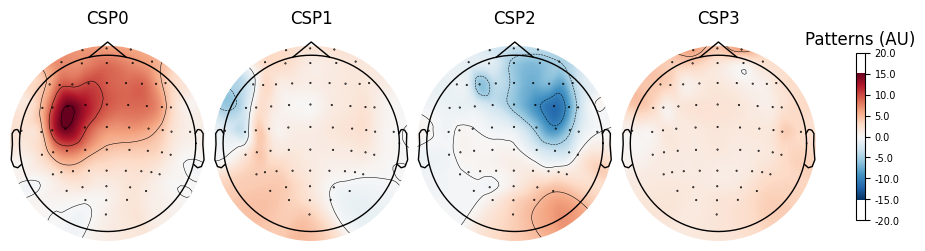

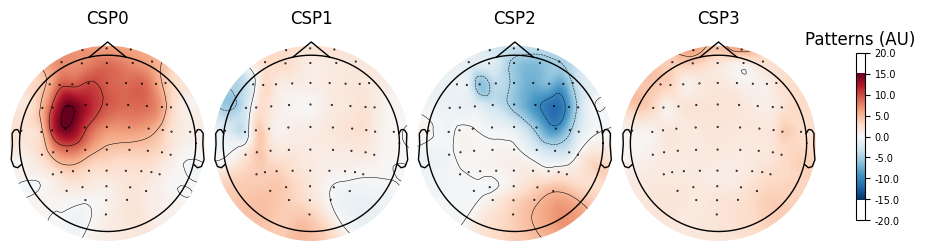

In [3]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data(copy=False)
epochs_data_train = epochs_train.get_data(copy=False)
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

Effective window size : 12.800 (s)


/Users/nana/opt/anaconda3/envs/eeg_decoder/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


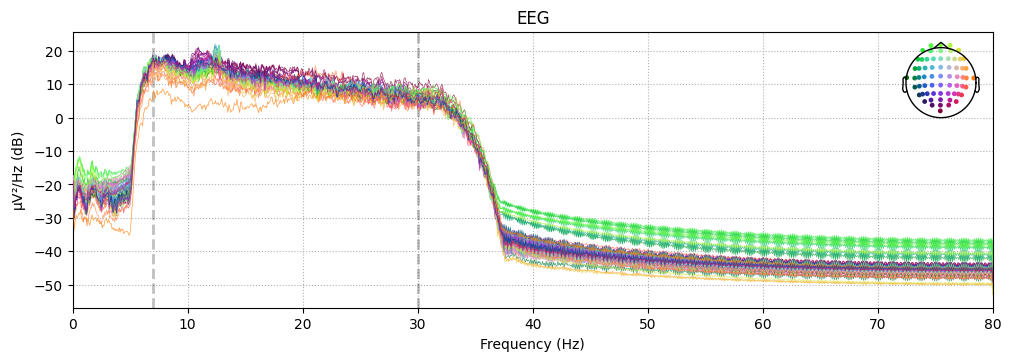

In [4]:
raw.compute_psd().plot()

Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


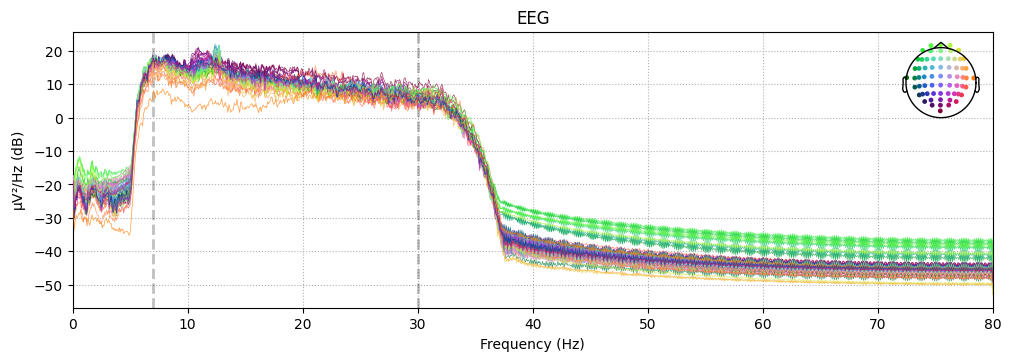

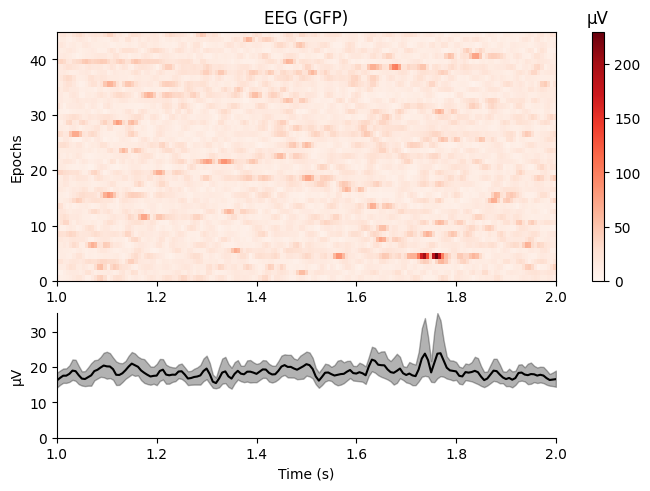

[<Figure size 640x480 with 3 Axes>]

In [5]:
epochs_train.plot_image()

In [7]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

/Users/nana/opt/anaconda3/envs/eeg_decoder/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nana/opt/anaconda3/envs/eeg_decoder/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: x and y must have same first dimension, but have shapes (46,) and (1,)

In [8]:
from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws
from mne.io.edf import read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [9]:
# cross validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
# get epochs
#epochs_data_train = 1e6 * epochs.get_data(copy=False) 

# compute covariance matrices
#cov_data_train = Covariances().transform(epochs_train)

In [10]:
# Assemble a classifier
lr = LogisticRegression()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)

clf = Pipeline([('CSP', csp), ('LogisticRegression', lr)])
scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("CSP + LDA Classification accuracy: %f / Chance level: %f" %
      (np.mean(scores), class_balance))

Computing rank from data with rank=None
    Using tolerance 0.00024 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00025 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00022 (2.2e-16 eps * 64 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00026 (2.2e-16 eps * 64 dim * 1.8e+10  max singular v

In [12]:
import pywt

def extract_wavelet_features(epochs, sampling_freq, wavelet='db4', num_levels=4):
    """
    Extract wavelet features from EEG epochs.

    Args:
        epochs (np.ndarray): 3D array of EEG epochs with shape (n_epochs, n_channels, n_samples)
        sampling_freq (float): Sampling frequency of the EEG data
        wavelet (str): Name of the wavelet family to use (default: 'db4')
        num_levels (int): Number of wavelet decomposition levels (default: 4)

    Returns:
        np.ndarray: 2D array of wavelet features with shape (n_epochs, n_features)
    """
    n_epochs, n_channels, n_samples = epochs.shape
    features = []

    for epoch in epochs:
        epoch_features = []
        for channel in epoch:
            # Perform wavelet decomposition
            coeffs = pywt.wavedec(channel, wavelet, level=num_levels)

            # Extract features from the detail coefficients
            channel_features = []
            for level in range(num_levels):
                detail_coeffs = coeffs[level]
                channel_features.extend([
                    np.mean(np.abs(detail_coeffs)),  # Mean of absolute values
                    np.std(detail_coeffs),  # Standard deviation
                    np.max(np.abs(detail_coeffs)),  # Maximum of absolute values
                ])

            epoch_features.append(channel_features)

        epoch_features = np.concatenate(epoch_features)
        features.append(epoch_features)

    features = np.array(features)
    return features

In [19]:
#wavelet features
wavelet_features = extract_wavelet_features(epochs_data, raw.info['sfreq'])
print(wavelet_features.shape)




(45, 768)


In [22]:
#svm classifier
from sklearn.svm import SVC

# import numpy as np
# from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(wavelet_features, labels, test_size=0.2, random_state=42)

# Create and train the SVM classifier
svm_clf = SVC(kernel='rbf', gamma='auto', C=1.0)  # You can adjust the hyperparameters
svm_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_clf.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM accuracy: {accuracy * 100:.2f}%")


SVM accuracy: 33.33%
